# Аналитика нефтедобывающей компании 🛢️

**Описание проекта:** с помощью машинного обучения определить, в каком регионе лучше всего бурить скважину добывающей компании «ГлавРосГосНефть».

**Цель проекта:** Построить модель и рассчитать показатели для определения региона, где добыча нефти принесёт наибольшую прибыль. 

**Ход исследования:** 

- Загрузка данных, предобработка. Исследовательский анализ данных. Оценка проб нефти в 3-х регионах;
- Корреляционный анализ
- Построение модели для предсказания объёма запасов в новых скважинах;
- Отбор скважин с самыми высокими оценками значений;
- Определение региона с максимальной суммарной прибылью отобранных скважин и вероятностью убытка < 0,025.


**Содержание**<a id='toc0_'></a> 

1. [Подготовка данных](#toc1_)                                  
  1.1 [Установка библиотек и конфигурации](#toc1_1_)    
  1.2 [Функции, используемые в проекте](#toc1_2_) 
  
2. [Предобработка данных и исследовательский анализ данных(EDA)](#toc2_)         
  2.1 [Датафрейм geo_data_0(geo_data_0.csv)](#toc2_1_)    
  2.2 [Датафрейм geo_data_1(geo_data_1.csv)](#toc2_2_)    
  2.3 [Датафрейм geo_data_2(geo_data_2.csv)](#toc2_3_)                        

3. [Корреляционный анализ](#toc3_)  

4. [Обучение модели и расчет среднего запаса сырья](#toc4_)                                               
  
5. [Подготовка к расчету прибыли](#toc5_)

6. [Расчет прибыли и рисков](#toc6_)

7. [Общий вывод](#toc7_)



## <a id='toc1_'></a> 1. Подготовка данных[&#8593;](#toc0_)

### <a id='toc1_1_'></a> 1.1 Установка библиотек  и конфигурации [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
from platform import python_version
version = python_version()

if version.startswith('3.9'):  
    pass
    %pip install --force-reinstall -v "numpy==1.22.4" -q
else: 
    pass
    %pip install --upgrade numpy -q   

%pip install --force-reinstall -v "matplotlib==3.8.0" -q

%pip install --upgrade phik -q
%pip install --upgrade prettytable -q
%pip install --upgrade termcolor -q
%pip install --upgrade seaborn -q
%pip install --upgrade pandas -q
%pip install --upgrade statsmodels -q
%pip install --upgrade scikit-learn -q
%pip install --upgrade shap -q
%pip install --upgrade imbalanced-learn -q
%pip install --upgrade optuna -q

clear_output()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from os.path import exists

# preprocessing
from sklearn.preprocessing import (
    MinMaxScaler)

# models
from sklearn.linear_model import LinearRegression

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from phik import phik_matrix  # this import IS accessed
from prettytable import PrettyTable
from termcolor import colored
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)

### <a id='toc1_2_'></a> 1.2 Функции, используемые в проекте [&#8593;](#toc0_)

In [5]:
def get_dataframe(paths: list[str]) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue
        
        try:
            df = pd.read_csv(_path)
        except:
            continue
        
        if df is None:
            continue
        
        return df
    
    raise FileNotFoundError('No paths are valid and/or for correct csv file.')

In [6]:
def print_nans_table(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Признаки', 'Пропущенное количество значений']
    
    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'blue' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.1%})'
        table.add_row([col, colored(s, color)])
    
    print(table)

In [7]:
def the_basic_plots(df: pd.DataFrame,
                    column: str,
                    column_description: str,
                    bins: int = 25
                    ) -> None:
    
    _, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 6))

    sns.boxplot(data=df, x=column, ax=ax1)
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.histplot(data=df, x=column, bins=bins, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()
    ax2.set_ylabel('Количество')

    plt.suptitle(f'Информация о колонке {column_description}', fontsize=18)
    plt.tight_layout()

    plt.show()

In [8]:
def get_plots_about_residuals(y_true: np.array, y_pred: np.array) -> None:
    res = y_true - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.histplot(res, ax=ax1)
    ax1.set_xlabel('Остатки')
    ax1.set_ylabel('Количество')
    ax1.axvline(x=0, color='green', lw=3, ls='-', label='Нулевое значение')
    ax1.axvline(x=res.mean(), color='red', lw=3, ls='--', label='Среднее значение остатков')
    ax1.legend()
    
    sns.scatterplot(x=y_pred, y=res, ax=ax2)
    ax2.set_xlabel('Предсказанные значение')
    ax2.set_ylabel('Остатки')
    
    fig.suptitle('Информация об остатках')

In [9]:
def get_predict_f (df: pd.DataFrame, target: str) -> tuple[pd.Series, pd.Series]:
    X,y = df.drop(columns=target), df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        shuffle=True,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(f'Предсказанный средний запас нефти = {y_pred.mean():5.2f}')
    print(f'RMSE = {rmse:5.2f}')

    y_test = y_test.reset_index(drop=True)
    return y_test, pd.Series(y_pred, name='product')

## <a id='toc2_'></a> 2. Предобработка и исследовательский анализ данных(EDA) [&#8593;](#toc0_)

### <a id='toc2_1_'></a> 2.1 Датафрейм geo_data_0 (geo_data_0.csv) [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [10]:
geo_data_0 = get_dataframe(['/datasets/geo_data_0.csv'])

In [11]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


2. Проверим типы данных и пропуски:

In [12]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
print_nans_table(geo_data_0)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|    id    |             0 (0.0%)            |
|    f0    |             0 (0.0%)            |
|    f1    |             0 (0.0%)            |
|    f2    |             0 (0.0%)            |
| product  |             0 (0.0%)            |
+----------+---------------------------------+


Пропусков нет.

3. Посмотрим на дубликаты:

In [14]:
geo_data_0.duplicated().sum()

0

Дубликатов нет, значения принаков количественные, поэтому можем за индексы принять столбец *id*:

In [15]:
geo_data_0 = geo_data_0.set_index('id').sort_index()

In [16]:
geo_data_0.duplicated().sum()

0

**Вывод:**
Дубликатов, пропусков и ошибок в типах значений признаков нет.

**Далее перейдем к исследовательскому анализу данных(EDA).**

1. Столбец f0:

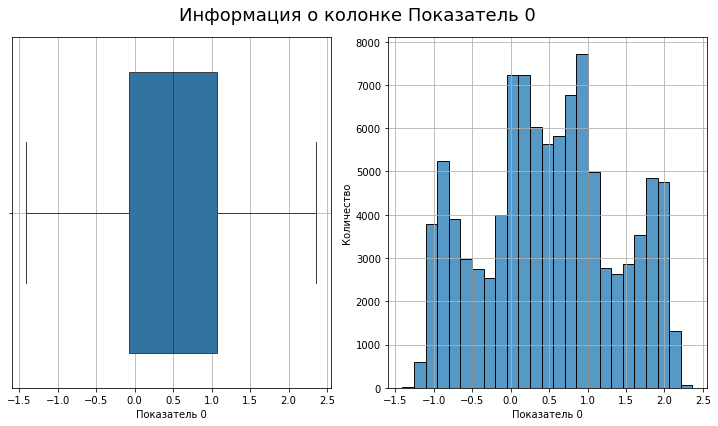

In [17]:
the_basic_plots(geo_data_0, 'f0', 'Показатель 0')

О характере распределения сложно что-то сказать по виду графика. Но видим 4 явных пика

2. Столбец f1:

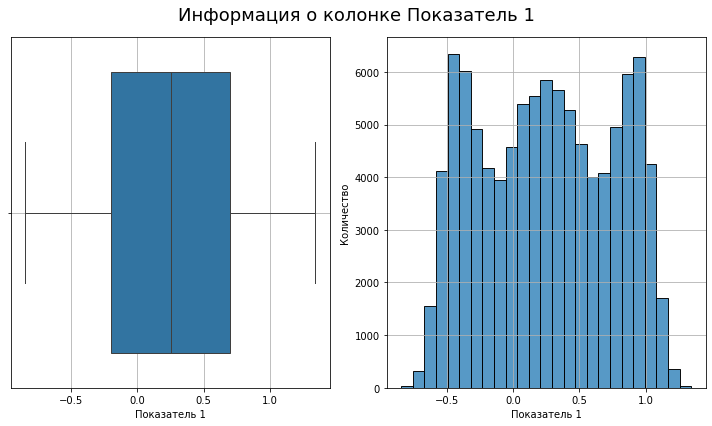

In [18]:
the_basic_plots(geo_data_0, 'f1', 'Показатель 1')

Показатели 0 и 1 похожи по характеру распределения.

3. Столбец f2:

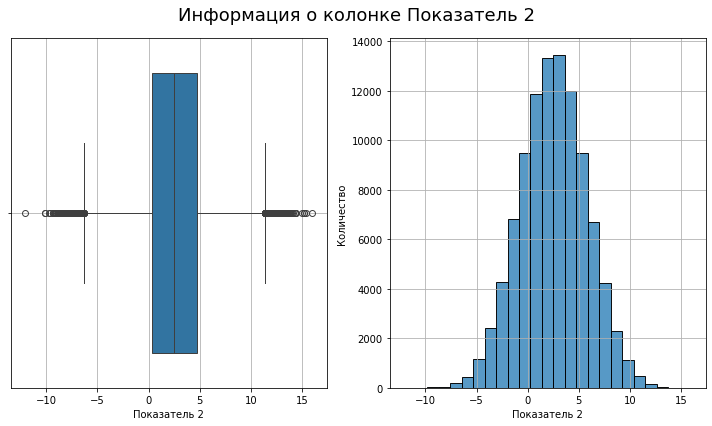

In [19]:
the_basic_plots(geo_data_0, 'f2', 'Показатель 2')

Здесь явное нормальное распределение с медианным значением в районе 2,5

4. Столбец product:

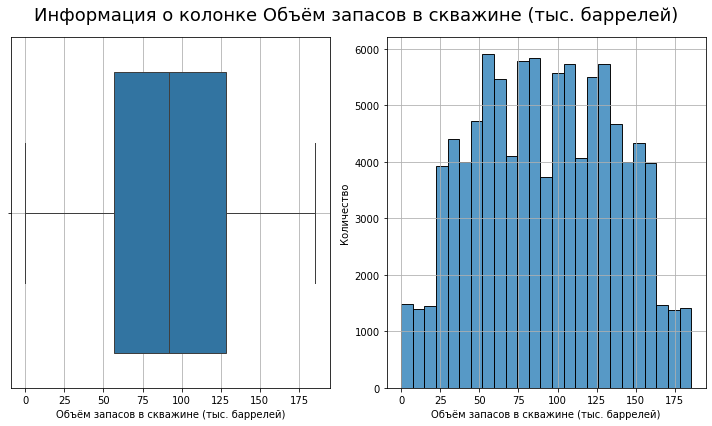

In [20]:
the_basic_plots(geo_data_0, 'product', 'Объём запасов в скважине (тыс. баррелей)')

Характер распределения нельзя определить однозначно так же

**Вывод**:

Провели первичную предобработку данных, дубликатов и пропусков не оказалось. Присутствуют признаки только числового непрерывного типа. О характерах распределения сказать что-то однозначно сложно, за исключением признака f2-нормально распределенная величина.

Целевой признак так же не имеет однозначно выраженного типа распределения.

### <a id='toc2_2_'></a> 2.2 Датафрейм geo_data_1 (geo_data_1.csv) [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [21]:
geo_data_1 = get_dataframe(['/datasets/geo_data_1.csv'])

In [22]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


2. Проверим типы данных и пропуски:

In [23]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [24]:
print_nans_table(geo_data_1)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|    id    |             0 (0.0%)            |
|    f0    |             0 (0.0%)            |
|    f1    |             0 (0.0%)            |
|    f2    |             0 (0.0%)            |
| product  |             0 (0.0%)            |
+----------+---------------------------------+


Типы данных корректны и пропусков нет

3. Проверим дубликаты:

In [25]:
geo_data_1.duplicated().sum()

0

In [26]:
geo_data_1 = geo_data_1.set_index('id').sort_index()

In [27]:
geo_data_1.duplicated().sum()

0

In [28]:
geo_data_1.head()

,f0,f1,f2,product
id,,,,
0022J,-1.76,-8.43,2.00,53.91
003Gl,2.86,-2.62,2.00,57.09
003Vx,3.48,-16.40,3.00,80.86
004LG,5.63,5.15,3.00,80.86
006oG,-4.95,-11.78,5.00,137.95


**Далее перейдем к исследовательскому анализу данных(EDA).**

1. Столбец f0:

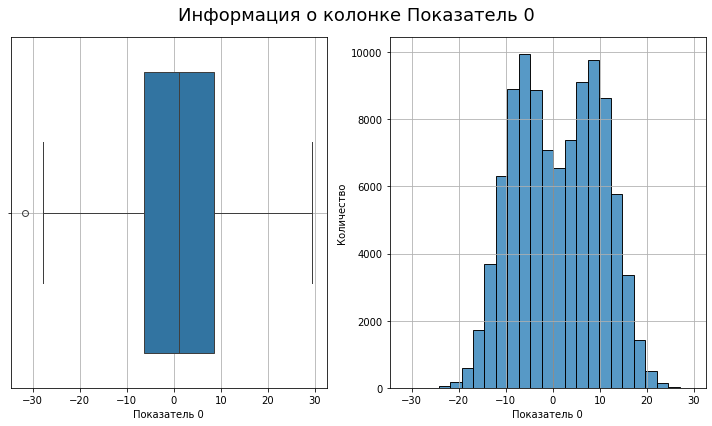

In [29]:
the_basic_plots(geo_data_1, 'f0', 'Показатель 0')

Бимодальное нормальное распределение

2. Столбец f1:

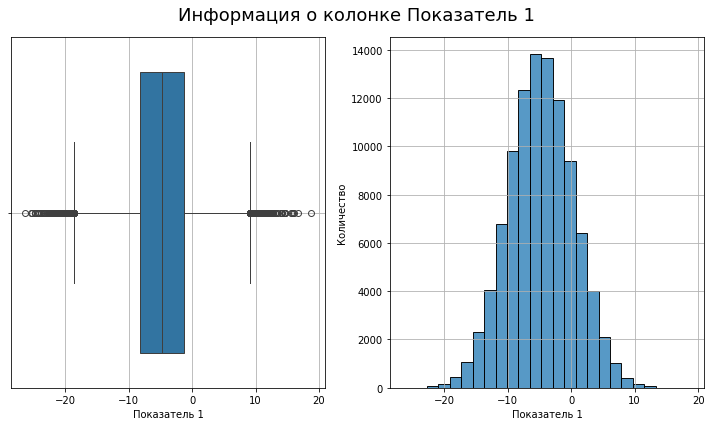

In [30]:
the_basic_plots(geo_data_1, 'f1', 'Показатель 1')

Здесь наблюдаем явное нормальное распределение

3. Столбец f2:

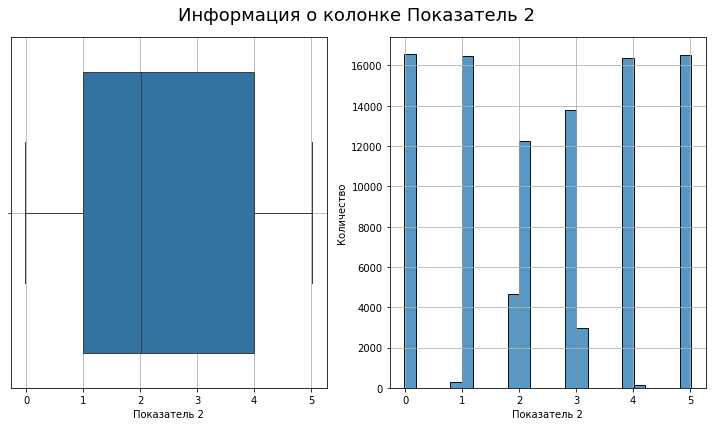

In [31]:
the_basic_plots(geo_data_1, 'f2', 'Показатель 2')

In [32]:
geo_data_1['f2'].value_counts()

f2
2.00     1
3.00     1
4.00     1
2.99     1
0.01     1
        ..
4.00     1
2.00     1
-0.01    1
2.99     1
2.99     1
Name: count, Length: 100000, dtype: int64

Значения сконцентрированы около целых

4. Столбец product:

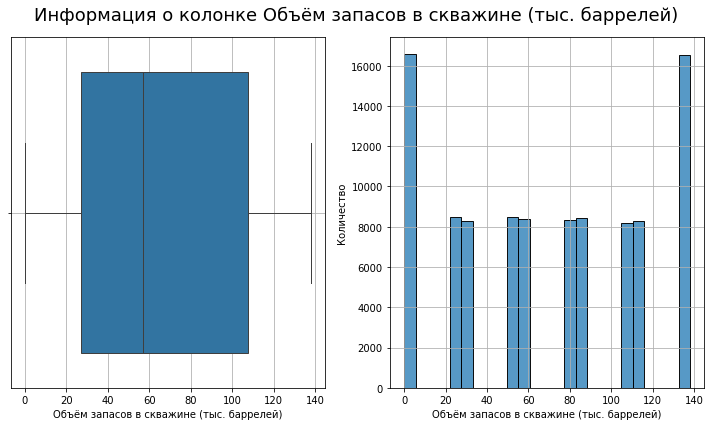

In [33]:
the_basic_plots(geo_data_1, 'product', 'Объём запасов в скважине (тыс. баррелей)')

Целевой признак похож по распределению величины на признак f2. Необходимо учесть это при корреляционном анализе

**Вывод**:

Провели первичную предобработку данных, дубликатов и пропусков не оказалось. Присутствуют признаки только числового непрерывного типа. Два признака распределены нормально, Признаки f2 и целевой имеют подозрительно схожий вид распределений, возможно присутствует сильная корреляция.


### <a id='toc2_3_'></a> 2.3 Датафрейм geo_data_2 (geo_data_2.csv) [&#8593;](#toc0_)

1. Загрузим датафрейм:

In [34]:
geo_data_2 = get_dataframe(['/datasets/geo_data_2.csv'])

In [35]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


2. Проверим типы данных и пропуски:

In [36]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [37]:
print_nans_table(geo_data_2)

+----------+---------------------------------+
| Признаки | Пропущенное количество значений |
+----------+---------------------------------+
|    id    |             0 (0.0%)            |
|    f0    |             0 (0.0%)            |
|    f1    |             0 (0.0%)            |
|    f2    |             0 (0.0%)            |
| product  |             0 (0.0%)            |
+----------+---------------------------------+


Типы данных корректны, пропусков нет

3. Проверим дубликаты:

In [38]:
geo_data_2.duplicated().sum()

0

In [39]:
geo_data_2 = geo_data_2.set_index('id').sort_index()

In [40]:
geo_data_2.duplicated().sum()

0

In [41]:
geo_data_2.head()

,f0,f1,f2,product
id,,,,
009Gl,0.56,-1.77,4.65,130.62
00AuD,0.90,0.30,6.03,112.89
00CaL,-1.02,-0.74,4.24,132.79
00Cby,-1.18,2.33,2.69,97.17
00NQN,-1.48,0.46,2.03,85.89


**Далее перейдем к исследовательскому анализу данных(EDA).**

1. Столбец f0:

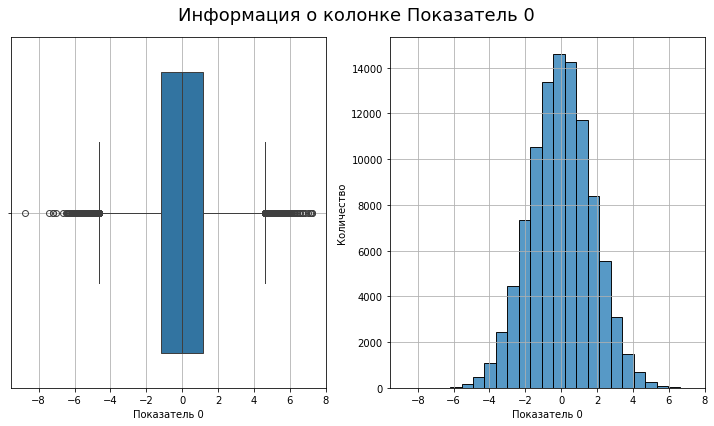

In [42]:
the_basic_plots(geo_data_2, 'f0', 'Показатель 0')

Явное нормальное распределение

2. Столбец f1:

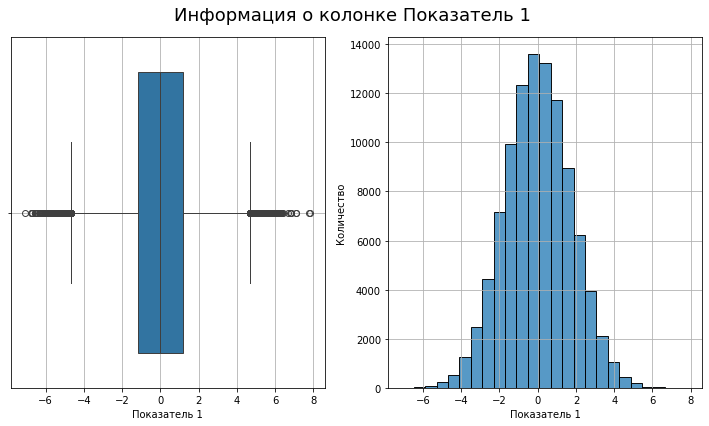

In [43]:
the_basic_plots(geo_data_2, 'f1', 'Показатель 1')

Здесь так же нормальное распределение

3. Столбец f2:

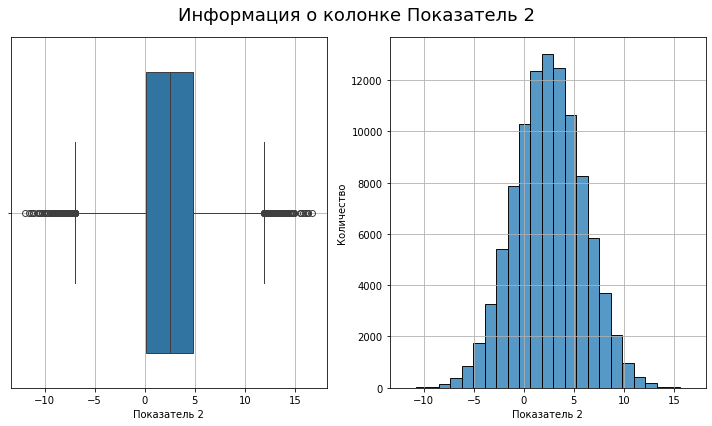

In [44]:
the_basic_plots(geo_data_2, 'f2', 'Показатель 2')

3. Столбец product:

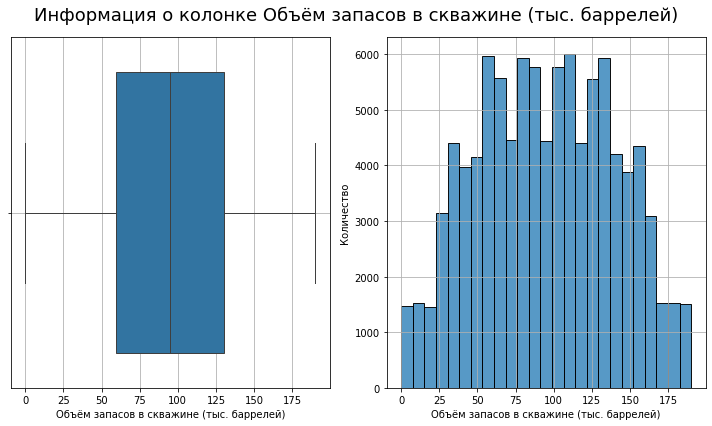

In [45]:
the_basic_plots(geo_data_2, 'product', 'Объём запасов в скважине (тыс. баррелей)')

**Вывод**:

Провели первичную предобработку данных, дубликатов и пропусков не оказалось. Присутствуют признаки только числового непрерывного типа. Три входных признака распределены нормально, распределение целевого признака похоже на анлогичное датасета geo_data_0.


## <a id='toc3_'></a> 3. Корреляционный анализ [&#8593;](#toc0_)

Проанализируем phik корреляцию для всех 3-х датасетов:

1. geo_data_0

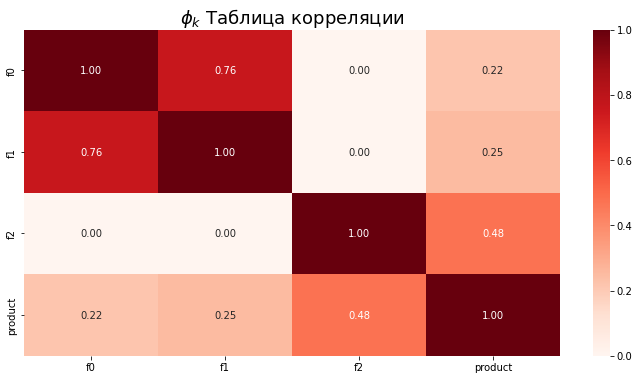

In [46]:
plt.figure(figsize=(12, 6))
sns.heatmap(geo_data_0.phik_matrix(interval_cols=geo_data_0.columns),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции', fontsize=18);

Есть корреляция между признаком f1 и f0.

2. geo_data_1

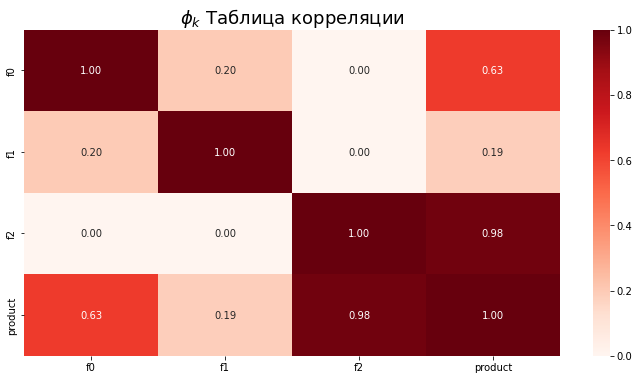

In [47]:
plt.figure(figsize=(12, 6))
sns.heatmap(geo_data_1.phik_matrix(interval_cols=geo_data_1.columns),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции', fontsize=18);

Как и было замечено ранее, признак f2 сильно коррелирует с целевым. Скорее всего это произошло из-за "искусственно сформированных данных".

3. geo_data_2

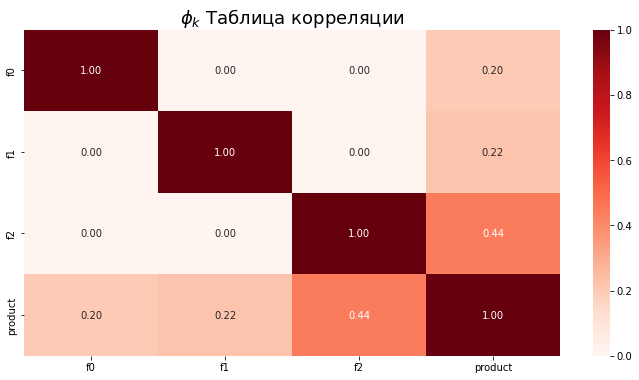

In [48]:
plt.figure(figsize=(12, 6))
sns.heatmap(geo_data_2.phik_matrix(interval_cols=geo_data_2.columns),
            cmap='Reds',
            annot=True,
            fmt='.2f')
plt.title(r'$\phi_k$ Таблица корреляции', fontsize=18);

В данном датасете нет коррелирующих признаков.

## <a id='toc4_'></a> 4. Обучение модели и расчет среднего запаса сырья [&#8593;](#toc0_)

1. Датасет geo_data_0

In [49]:
target = 'product'

In [50]:
y_true0, y_pred0 = get_predict_f(geo_data_0, target)

Предсказанный средний запас нефти = 92.34
RMSE = 37.75


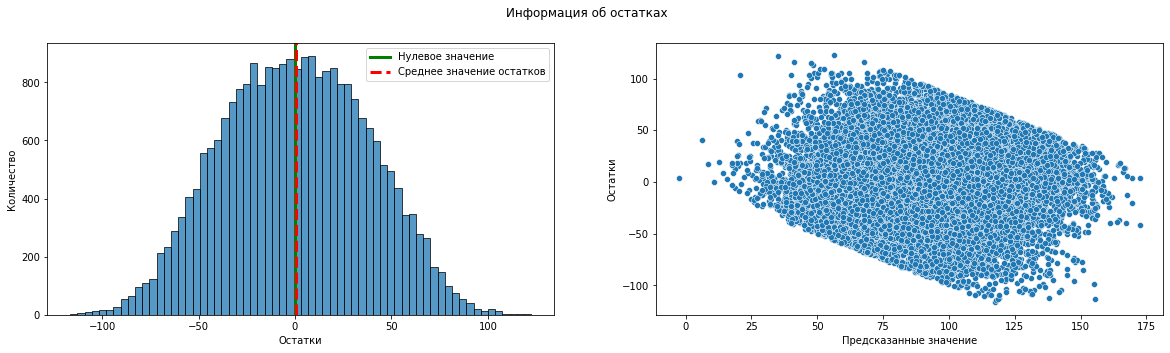

In [51]:
get_plots_about_residuals(y_true0, y_pred0)

Остатки распределены нормально. Дисперсия почти равномерная.

2. Датасет geo_data_1

In [52]:
y_true1, y_pred1 = get_predict_f(geo_data_1, target)

Предсказанный средний запас нефти = 68.70
RMSE =  0.89


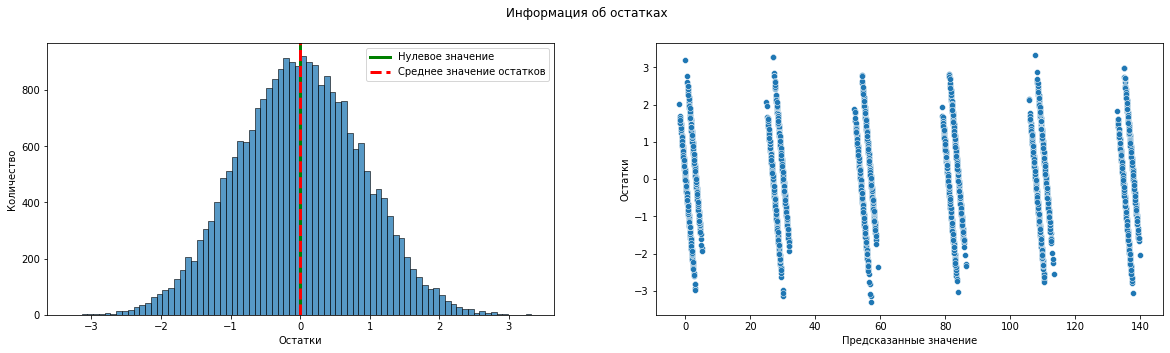

In [53]:
get_plots_about_residuals(y_true1, y_pred1)

Значения остатков так же нормально распределены. Дисперсия обуславливается распределением целевого признака (значения сгруппированы рядом с конкретными значениями). 

3. Датасет geo_data_2

In [54]:
y_true2, y_pred2 = get_predict_f(geo_data_2, target)

Предсказанный средний запас нефти = 95.01
RMSE = 40.08


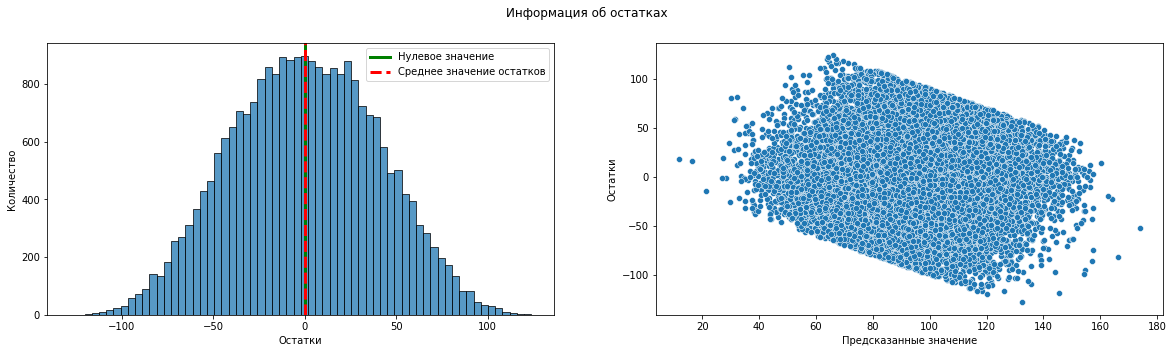

In [55]:
get_plots_about_residuals(y_true2, y_pred2)

Аналогичные первому датасету графики.

**Вывод**:

Стоит заметить, что первый и третий датасеты похожи по своим высоким значениям среднего предсказанного сырья (>90 тыс. баррелей), однако и метрика RMSE довольно высока, в отличие от второго датасета, в котором средний показатель сырья ниже почти в 1,5 раза, но и метрика очень низкая, что можно обусловить фактом сильной корреляции признаков f2 и целевого.

Дисперсия для 0 и 2 датасетов показывает:

- Для малоемких скважин предсказания выше реальных значений.
- Для вместительных скважин предсказанные значения ниже реальных.


## <a id='toc4_'></a> 5. Подготовка к расчету прибыли [&#8593;](#toc0_)

In [56]:
BUDGET_DIV = 10_000_000_000
REV_PER_U = 450_000
N_SEL = 500
N_BEST = 200

In [57]:
print(f'Необходимое количество запасов для безубыточной разработки скважины = {BUDGET_DIV/(REV_PER_U*N_BEST):5.0f}')

Необходимое количество запасов для безубыточной разработки скважины =   111


**Вывод**: Необходимо как минимум 111 тыс. баррелей для безубыточной разработки скважины. Это выше любого среднего значения для всех 3-х выборок, но 200 лучших со значениями>111 с помощью бутстрепа найти сможем. 

## <a id='toc6_'></a> 6. Расчет прибыли и рисков [&#8593;](#toc0_)

In [58]:
def risk_rev(y_true: pd.Series, y_pred: pd.Series) -> None:
    def revenue(y_true: pd.Series, y_pred: pd.Series)-> float:
        y_pred_sorted = y_pred.sort_values(ascending=False)
        y_true_sorted = y_true[y_pred_sorted.index]
        selected = y_true_sorted[:N_BEST]
        
        return  REV_PER_U * selected.sum()
        
    state = np.random.RandomState(RANDOM_STATE)
    
    values = []
    for i in range(1000):
        y_true_subsample = y_true.sample(N_SEL, replace=True, random_state=state)
        y_pred_subsample =  y_pred[y_true_subsample.index]
        profit = revenue(y_true_subsample,y_pred_subsample) - BUDGET_DIV
        values.append(profit) 
                      
    values = pd.Series(values)
    mean = values.mean()
    pr_loss = (values < 0).mean()
    print(f'Среднее значение прибыли: {values.mean():,.0f}')
    print('95%-ый доверительный интервал',values.quantile(0.025),'-',values.quantile(0.975))
    print(f'Вероятность убыточности разработки региона: {pr_loss:.1%}')

In [59]:
risk_rev(y_true0, y_pred0)

Среднее значение прибыли: 490,918,609
95%-ый доверительный интервал -19275952.334459193 - 1032838020.7345014
Вероятность убыточности разработки региона: 3.0%


In [60]:
risk_rev(y_true1, y_pred1)

Среднее значение прибыли: 502,769,745
95%-ый доверительный интервал 98054277.0926868 - 916534106.5305394
Вероятность убыточности разработки региона: 0.7%


In [61]:
risk_rev(y_true2, y_pred2)

Среднее значение прибыли: 406,299,190
95%-ый доверительный интервал -137162603.11120033 - 936861984.8530523
Вероятность убыточности разработки региона: 7.2%


## <a id='toc7_'></a> 7. Общий вывод [&#8593;](#toc0_)

Целью данного проекта являлось определение региона для разработки новых скважин с целью добычи нефти.

Для этого было проанализированы данные для трех регионов:

- Проведена предобработка данных
- Проведен исследовательский и корреляционный анализ данных, в ходе которого было выявлено, что для второго региона влияние 2-го входного признака на целевой превалирующее (имеет высокую корреляцию, что скорее говорит о "синтетике" данных скорее).
- Построена модель для предсказания запасов нефти в скважинах.
- Определено среднее количество предсказанных запасов нефти (от 68 до 95 тыс. баррелей) и необходимое для безубыточной разработки скважины - 111 тыс. баррелей.
- На основе модели с помощью техники Bootstrap была сформирована выборка с прибылью: из 500 случайно выбранных скважин выбиралось 200 по наибольшему количеству пердсказанных запасов нефти.

  Итоги исследования:
  Единственным подходящим для разработки региона стал 2-й с риском убыточности в 0,7%(<2,5%) и средним значением прибыли почти в 503 млн.

